# Imports

In [61]:
import pandas as pd
import numpy as np

from collections import defaultdict

from tensorflow import keras

from matplotlib import pyplot as plt

import copy

from functions.data_processing import create_set as s
from functions.prediction import make_predictions, generate_pdda_preds
from functions.visualization import posHeatmapXY, spatial_plot

import warnings
warnings.filterwarnings("ignore")

# Dataset Import

The dataset is hosted publicly at https://doi.org/10.5281/zenodo.6303665.

In [46]:
datadir = 'Dataset' # path to data folder
modeldir = 'models' # path to model folder (optional, if you want to save models' weights)
preds_dir = 'preds' # path to model folder (optional, if you want to save models' predictions)

In [47]:
import json
import os
os.getcwd()

'C:\\Users\\nini\\Desktop\\Libra\\sensors-positioning'

In [48]:
#define basic values
rooms = ['testbench_01', 'testbench_01_furniture_low', 'testbench_01_furniture_mid', 'testbench_01_furniture_high']
concrete_rooms = ['testbench_01_furniture_low_concrete', 'testbench_01_furniture_mid_concrete', 'testbench_01_furniture_high_concrete']
other_scenarios = ['testbench_01_rotated_anchors']
anchors = ['anchor1', 'anchor2', 'anchor3', 'anchor4']
channels = ['37','38','39']
polarities = ['V','H']

In [49]:
#read data
data = defaultdict(lambda: defaultdict(lambda: defaultdict (lambda: defaultdict(list))))

anchor_data = defaultdict(lambda: defaultdict(lambda: defaultdict (lambda: defaultdict(list))))
final_df = pd.DataFrame()
for room in rooms + concrete_rooms + other_scenarios: 
    for channel in channels:  
        for polarity in polarities: 
             
            tag_filename = f'{datadir}/{room}/tag_ml_export_CH{channel}_{polarity}.json'
            with open(tag_filename, encoding='utf-8-sig') as fp:
                tag_dataset = json.loads(''.join(line.strip() for line in fp))

            tag_df = pd.json_normalize(tag_dataset)
            tag_df['room'] = str(room)
            tag_df['channel'] = str(channel)
            tag_df['polarity'] = str(polarity)
            # tag_df = pd.read_json(tag_filename, orient='records')
            
            anchor_filename = f'{datadir}/{room}/anchor_ml_export_CH{channel}_{polarity}.json'
            
            with open(anchor_filename, encoding='utf-8-sig') as fp:
                anchor_dataset = json.loads(''.join(line.strip() for line in fp))

            anchor_df = pd.json_normalize(anchor_dataset)
            
            # anchor_df = pd.read_json(anchor_filename, orient='records')

            df = tag_df.merge(anchor_df)
            # remove calibration points
            df.drop(df[(df['x_tag']==0).values | (df['y_tag']==0).values | (df['z_tag']==0).values].index, inplace=True)
            for anchor in anchors:
                data[room][anchor][channel][polarity] = df[df['anchor']==int(anchor[-1])]
                anchor_data[room][anchor][channel][polarity] = anchor_df
            final_df = pd.concat([final_df, df])

In [50]:
cols = list(final_df)
cols

['anchor',
 'point',
 'x_tag',
 'y_tag',
 'z_tag',
 'los',
 'relative_power',
 'pdda_input_real',
 'pdda_input_imag',
 'pdda_phi',
 'pdda_theta',
 'pdda_out_az',
 'pdda_out_el',
 'true_phi',
 'true_theta',
 'room',
 'channel',
 'polarity',
 'x_anchor',
 'y_anchor',
 'z_anchor',
 'az_anchor',
 'el_anchor',
 'reference_power']

In [51]:
new_order = [ 'point','room','anchor','channel', 'polarity', 'reference_power','pdda_input_real','pdda_input_imag', 'relative_power', 'x_tag', 'y_tag', 'z_tag'] 
new_order += list((set(cols) - set(new_order)))

In [52]:
final_df = final_df[new_order]
final_df = final_df.sort_values(['point', 'room', 'anchor', 'channel', 'polarity'])
final_df.reset_index(drop=True, inplace=True)

In [53]:
final_df.to_pickle('libra_dataset.pkl')

# final_df.to_pickle('libra_dataset.pkl')

# Data Processing

The selected number of training and validation points is small so the point selection is done in an orderly fashion.

In [54]:
#split points into train/test/val points
points = data['testbench_01']['anchor1']['37']['H'].iloc[:, 1:7]

# only point locations that appear in all simulated environments are used.
# some point locations that fall ontop of furniture are thus thrown away.
for room in rooms + concrete_rooms:
    for anchor in anchors:
        for channel in channels:
            for polarization in ['H','V']:
                points = pd.merge(points, data[room][anchor][channel][polarization]['point'], on='point')

# grid of training points
xs = sorted(np.unique(points['x_tag']))[::18]
ys = sorted(np.unique(points['y_tag']))[::9]
train_points = points[points['x_tag'].isin(xs) & points['y_tag'].isin(ys)]

# grid of validation points
xs = sorted(np.unique(points['x_tag']))[3::10]
ys = sorted(np.unique(points['y_tag']))[3::10]
val_points = points[points['x_tag'].isin(xs) & points['y_tag'].isin(ys)]

test_points = points.drop(index=train_points.index).drop(index=val_points.index)

In [55]:
points.to_pickle('points.pkl')

In [56]:
len(sorted(np.unique(points['x_tag'])))

70

In [57]:
print(f'Training Set Size:\t{len(train_points)}')
print(f'Validation Set Size:\t{len(val_points)}')
print(f'Testing Set Size:\t{len(test_points)}')

Training Set Size:	14
Validation Set Size:	27
Testing Set Size:	2353


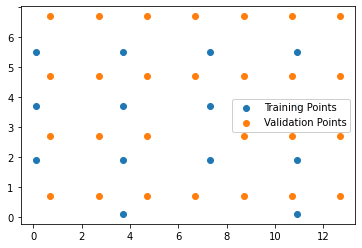

In [58]:
plt.scatter(train_points.iloc[:,1:2].values,train_points.iloc[:,2:3].values)
plt.scatter(val_points.iloc[:,1:2].values,val_points.iloc[:,2:3].values)
plt.legend(['Training Points', 'Validation Points'], framealpha=0.94, fancybox=True)
ax = plt.gca()
ax.set_xticklabels(range(-2,15,2))
ax.set_yticklabels(range(-1,7,1))
plt.show()

In [59]:
points

,point,x_tag,y_tag,z_tag,los,relative_power
0,2,44.1,43.3,1.5,1,-20.5
1,3,44.1,43.5,1.5,1,-21.0
2,4,44.1,43.7,1.5,1,-19.4
3,5,44.1,43.9,1.5,1,-18.2
4,6,44.1,44.1,1.5,1,-16.1
...,...,...,...,...,...,...
2389,2446,57.9,49.1,1.5,1,-13.9
2390,2447,57.9,49.3,1.5,1,-16.0
2391,2448,57.9,49.5,1.5,1,-15.3
2392,2449,57.9,49.7,1.5,1,-14.1


Split the dataset based on the picked training, validation and testing points. The create_set function processes the IQ and RSSI data by applying IQ phase shifting and RSSI normalization. 

The training set is augmented by reducing amplitude of IQ values and RSSI for randomly picked anchors.

In [62]:
#creat train/test/val sets
x_train, y_train = s(data, rooms, train_points, augmentation=True)
# x_val, y_val = create_set(data, rooms + concrete_rooms + other_scenarios, val_points)                         
# x_test, y_test = create_set(data, rooms + concrete_rooms + other_scenarios, test_points)

KeyError: 'power'

In [137]:
x_train['testbench_01']['anchor1']['37']

,pdda_input_real_1,power,pdda_input_real_2,pdda_input_imag_2,pdda_input_real_3,pdda_input_imag_3,pdda_input_real_4,pdda_input_imag_4,pdda_input_real_5,pdda_input_imag_5
0,0.133689,-0.075144,0.117261,0.009927,0.081547,0.020524,0.056636,-0.101402,-0.055464,-0.049822
1,0.118536,-0.019963,0.107362,0.004498,0.082752,0.018189,0.020275,-0.152259,-0.167982,-0.085364
2,0.139880,-0.014445,0.150061,0.002230,0.141142,-0.000025,0.059384,-0.121132,-0.077857,-0.097887
3,0.217890,0.054530,0.221963,-0.016463,0.212131,-0.035354,0.066006,-0.195575,-0.129932,-0.062551
4,0.084308,-0.102734,0.086392,0.045999,0.082037,0.088123,0.038903,-0.074308,-0.055138,-0.066021
...,...,...,...,...,...,...,...,...,...,...
135,0.108486,0.002109,0.054711,-0.019400,0.003459,-0.077888,-0.071544,0.197793,-0.239259,0.104831
136,0.280671,0.115228,0.070937,-0.018878,-0.117495,-0.141967,0.079744,0.289251,-0.200667,0.186776
137,0.033124,-0.003582,0.013233,-0.002318,-0.009120,-0.023191,0.019446,0.043957,-0.023318,0.034048
138,0.114320,-0.047553,0.120466,-0.042356,0.122193,-0.067901,-0.012341,0.153018,-0.125245,0.040751


In [140]:
df.head(-20)

,anchor,point,x_tag,y_tag,z_tag,los,relative_power,pdda_input_real,pdda_input_imag,pdda_phi,...,pdda_out_az,pdda_out_el,true_phi,true_theta,x_anchor,y_anchor,z_anchor,az_anchor,el_anchor,reference_power
1,1,2,44.1,43.3,1.5,1,-21.9,"[0.12804, 0.08455, 0.03672, 0.02623, -0.03455]","[0.01173, -0.0066, -0.01816, -0.0619, 0.03829]",70.6,...,"[0.02409, 0.02412, 0.02422, 0.02438, 0.02461, ...","[0.05467, 0.05471, 0.05483, 0.05503, 0.05531, ...",50.0,-4.1,57.9,43.3,2.5,130.0,0.0,-30.8
2,1,3,44.1,43.5,1.5,1,-27.6,"[0.00534, -0.01173, -0.02726, -0.01143, 0.03826]","[-0.03683, -0.04686, -0.04331, 0.01079, 0.02641]",90.5,...,"[0.069, 0.0691, 0.06941, 0.06992, 0.07065, 0.0...","[0.11515, 0.11531, 0.11579, 0.11659, 0.11772, ...",49.2,-4.1,57.9,43.3,2.5,130.0,0.0,-30.8
3,1,4,44.1,43.7,1.5,1,-26.5,"[-0.01548, -0.02331, -0.03228, -0.02385, 0.02794]","[-0.04823, -0.05568, -0.04764, 0.00744, 0.01756]",67.5,...,"[0.04676, 0.04682, 0.04698, 0.04725, 0.04762, ...","[0.02732, 0.02738, 0.02758, 0.0279, 0.02836, 0...",48.3,-4.1,57.9,43.3,2.5,130.0,0.0,-30.8
4,1,5,44.1,43.9,1.5,1,-24.4,"[-0.02132, -0.01734, -0.02129, -0.04663, 0.00639]","[-0.06349, -0.0738, -0.06503, 0.00059, 0.02904]",45.9,...,"[0.04496, 0.04498, 0.04506, 0.04518, 0.04536, ...","[0.00457, 0.00459, 0.00465, 0.00476, 0.0049, 0...",47.5,-4.1,57.9,43.3,2.5,130.0,0.0,-30.8
5,1,6,44.1,44.1,1.5,1,-20.4,"[0.01018, 0.02177, 0.02018, -0.10022, -0.01718]","[-0.10761, -0.09481, -0.06984, -0.02339, 0.09292]",47.7,...,"[0.06139, 0.06143, 0.06156, 0.06177, 0.06206, ...","[0.0064, 0.00641, 0.00641, 0.00641, 0.00642, 0...",46.7,-4.1,57.9,43.3,2.5,130.0,0.0,-30.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9775,4,2426,57.9,45.1,1.5,1,-27.1,"[-0.01187, 0.00322, 0.01768, 0.03091, -0.00139]","[-0.0398, -0.04967, -0.05027, 0.01284, 0.04092]",-58.3,...,"[0.76498, 0.76509, 0.76541, 0.76594, 0.76668, ...","[0.02931, 0.02927, 0.02913, 0.0289, 0.02858, 0...",-32.5,-4.2,44.3,43.3,2.5,40.0,0.0,-30.8
9776,4,2427,57.9,45.3,1.5,1,-22.0,"[0.03371, 0.04247, 0.04125, -0.0442, -0.0601]","[0.05037, 0.07114, 0.08692, 0.0771, 0.01785]",-26.9,...,"[0.60243, 0.60273, 0.60362, 0.60511, 0.6072, 0...","[0.02416, 0.02417, 0.02419, 0.02423, 0.02429, ...",-31.6,-4.2,44.3,43.3,2.5,40.0,0.0,-30.8
9777,4,2428,57.9,45.5,1.5,1,-22.2,"[-0.03584, -0.04294, -0.05248, -0.06297, -0.02...","[0.06339, 0.08394, 0.0935, 0.00027, -0.0172]",-26.0,...,"[0.26382, 0.26393, 0.26426, 0.26481, 0.26557, ...","[0.01653, 0.01655, 0.01663, 0.01676, 0.01694, ...",-30.8,-4.2,44.3,43.3,2.5,40.0,0.0,-30.8
9778,4,2429,57.9,45.7,1.5,1,-25.1,"[-0.03061, -0.04984, -0.05959, 0.02604, 0.03516]","[-0.01431, -0.03952, -0.06347, -0.02961, 0.00495]",-43.6,...,"[0.84042, 0.84065, 0.84134, 0.84249, 0.8441, 0...","[0.2048, 0.20482, 0.20487, 0.20496, 0.2051, 0....",-30.0,-4.1,44.3,43.3,2.5,40.0,0.0,-30.8


In [91]:
import dill as pickle
with open("data.pkl", "wb") as pkl_handle:
    pickle.dump(data, pkl_handle)


In [96]:
with open("anchor_data.pkl", "wb") as pkl_handle:
    pickle.dump(anchor_data, pkl_handle)


In [23]:
with open("data.pkl", "rb") as pkl_handle:
    dataset = pickle.load(pkl_handle)

# Training

In [120]:
from functions.models import independentArch
model_arch = independentArch
model_arch_name = 'independent_arch'

In [121]:
#training parameters
fit_params = {'batch_size': 128, 'validation_batch_size':32, 'epochs': 1500, 'verbose': 1, 
              'callbacks': [keras.callbacks.EarlyStopping(monitor='val_mae', mode='min', verbose=0, patience=75, restore_best_weights=True)]}
learning_rate = 0.002

In [14]:
load = False # load an already saved model

if load:
    models_dict = {}
    for room in rooms:
        models_dict[room] = keras.load_model(f'{modeldir}/{model_arch_name}/{room}')

else:

    models_dict = defaultdict(lambda: model_arch(learning_rate).model)

    for training_room in rooms:

        print(training_room)
        models_dict[training_room] = model_arch(learning_rate).model

        ytrain = pd.concat([y_train[training_room][anchor]['37'] for anchor in anchors], axis=1)
        yval = pd.concat([y_val[training_room][anchor]['37'] for anchor in anchors], axis=1)

        models_dict[training_room].fit(x_train[training_room], ytrain,
                                    validation_data=(x_val[training_room], yval), 
                                    **fit_params)

testbench_01
Epoch 1/1500
34/34 [==============================] - 11s 45ms/step - loss: 460.1711 - mae: 16.4366 - val_loss: 364.9859 - val_mae: 13.4578
Epoch 2/1500
34/34 [==============================] - 0s 10ms/step - loss: 292.3166 - mae: 11.8078 - val_loss: 158.6019 - val_mae: 9.1318
Epoch 3/1500
34/34 [==============================] - 0s 9ms/step - loss: 152.4975 - mae: 8.3757 - val_loss: 101.5412 - val_mae: 6.9807
Epoch 4/1500
34/34 [==============================] - 0s 10ms/step - loss: 103.5414 - mae: 6.9375 - val_loss: 82.2830 - val_mae: 6.0863
Epoch 5/1500
34/34 [==============================] - 0s 11ms/step - loss: 78.9832 - mae: 6.1225 - val_loss: 70.2305 - val_mae: 5.3908
Epoch 6/1500
34/34 [==============================] - 0s 10ms/step - loss: 65.0219 - mae: 5.5098 - val_loss: 64.1787 - val_mae: 4.9266
Epoch 7/1500
34/34 [==============================] - 0s 10ms/step - loss: 56.6701 - mae: 5.1568 - val_loss: 62.6667 - val_mae: 4.8064
Epoch 8/1500
34/34 [============

In [26]:
save =  True # save the model

if save:
    for room in rooms:
        models_dict[room].save(f'{modeldir}/{model_arch_name}/{room}.h5')

# Predictions

In [16]:
# generate AoA and position predictions as well as mean euclidean distance error 
# and AoA mean absolute error for all training and testing room combinations
preds, true_pos = make_predictions(x_test, y_test, models_dict, training_rooms=rooms, 
                                        testing_rooms=rooms + concrete_rooms + other_scenarios,
                                        test_points=test_points, anchor_data=anchor_data)

In [17]:
def default_to_regular(d):
    if isinstance(d, (defaultdict, dict)):
        d = {k: default_to_regular(v) for k, v in d.items()}
    return d

In [22]:
# save the predictions dictionary
save_preds = False
if save_preds:
    results_path = f'{preds_dir}/preds_{model_arch_name}.npy'
    np.save(results_path, default_to_regular(preds))

In [19]:
# load the predictions dictionary
load_preds = False
if load_preds:
    preds = np.load(f'{preds_dir}/preds_{model_arch_name}.npy', allow_pickle=True)[()]

## PDDA

In [20]:
#produce pdda predictions
pdda_res = generate_pdda_preds(data, rooms + concrete_rooms + other_scenarios, test_points, anchor_data)

# Results

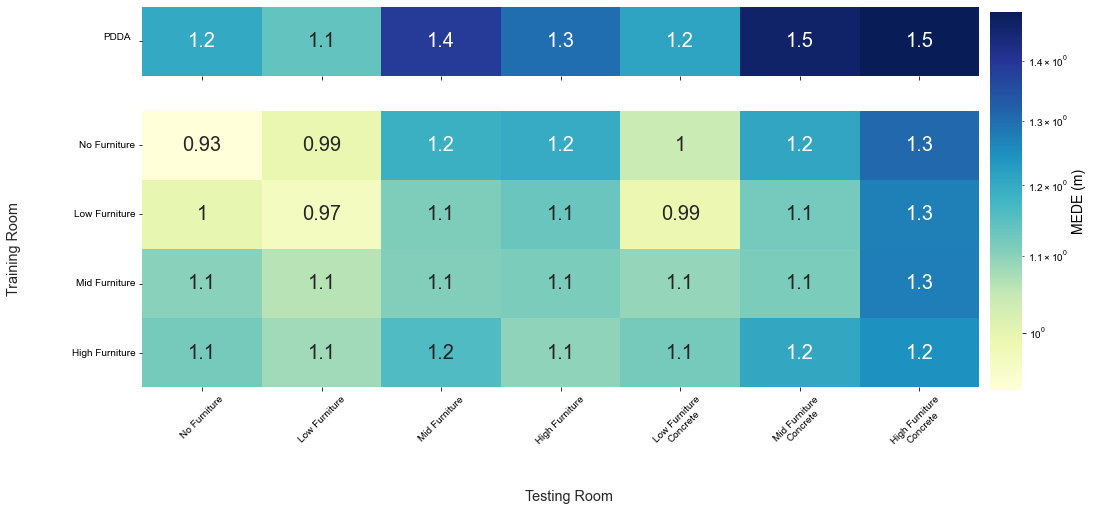

In [23]:
#produce pos maes heatmap
posHeatmapXY(preds['angle_'][:,:7], pdda_res['pos_maes'][:7])

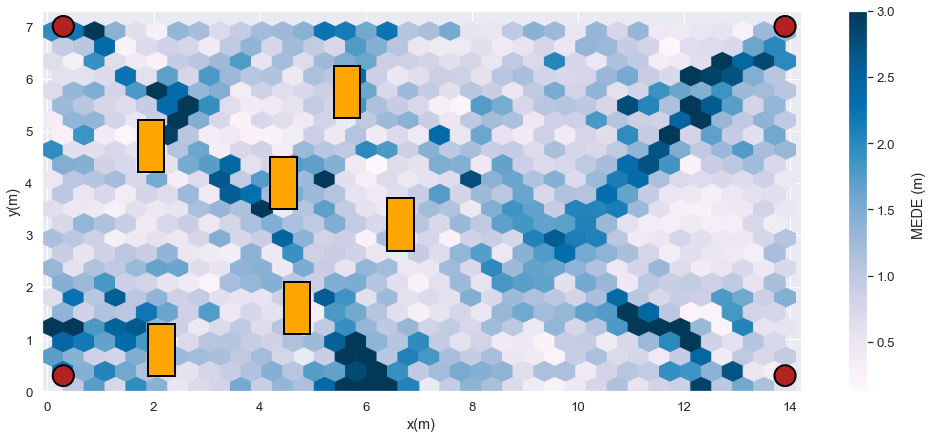

In [24]:
#produce error per point plot
spatial_plot(preds['pos_preds']['testbench_01_furniture_low']['testbench_01_furniture_high'], true_pos, testing_room = 'testbench_01_furniture_high', mode = 'xy',vmax = 3, cmap = 'PuBu')

In [209]:
keras_model = models_dict['testbench_01']

In [212]:
keras_model.summary()

Model: "model_20"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, 10)]         0                                            
___________________________________________________________________________________________

In [31]:
# Convert the model.
import tensorflow as tf
converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: C:\Users\nini\AppData\Local\Temp\tmpbgbqv2qs\assets


In [169]:
converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)

In [190]:
# Convert the model to the TensorFlow Lite format with quantization
import random
def representative_dataset():
    for i in range(len(x_val)):
        yield [x_val[i]]
    
converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# converter.representative_dataset = representative_dataset
# converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# converter.inference_input_type = tf.int8  # or tf.uint8
# converter.inference_output_type = tf.int8  # or tf.uint8
tflite_quant_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\nini\AppData\Local\Temp\tmp4leu1c0m\assets


INFO:tensorflow:Assets written to: C:\Users\nini\AppData\Local\Temp\tmp4leu1c0m\assets


In [ ]:
# model_no_quant_size = os.path.getsize(MODEL_DIR + 'model_no_quant.tflite')
# print("Model is %d bytes" % model_no_quant_size)
# model_size = os.path.getsize(MODEL_DIR + 'model.tflite')
# print("Quantized model is %d bytes" % model_size)
# difference = model_no_quant_size - model_size
# print("Difference is %d bytes" % difference)

In [206]:
keras_model_size = os.path.getsize('models/independent_arch/testbench_01.h5')
print("Keras Model is %d bytes" % keras_model_size)

quant_model_size = os.path.getsize('quantized.tflite')
print("Tensorflow Lite Model is %d bytes" % quant_model_size)

Keras Model is 600160 bytes
Tensorflow Lite Model is 101840 bytes


In [201]:
# Save the model.
with open('quantized.tflite', 'wb') as f:
    f.write(tflite_quant_model)

In [208]:
keras_model['testbench_01'].summary

TypeError: 'Functional' object is not subscriptable